# Protein Linker and Domain Analysis

This notebook analyzes protein linker regions and domains, including:

## Features

### Linker Analysis
- **analyze_linkers()**: Analyzes amino acid composition and length distribution for N-terminus, C-terminus, and inner linkers
- **visualize_linker_composition()**: Creates visualizations including:
  - Individual amino acid distributions for each linker type
  - Percentage composition comparison
  - Length distribution box plots with statistics

### Domain Analysis
- **analyze_domains()**: Analyzes amino acid composition and length distribution for all domains
- **visualize_domain_composition()**: Creates visualizations including:
  - Domain amino acid distribution
  - Percentage composition
  - Length distribution box plot

### Comparison Analysis
- **compare_domains_vs_linkers()**: Direct comparison of amino acid composition between domains and linkers

## Outputs
All visualizations are saved to the specified directory as high-resolution PNG files (300 DPI).

In [ ]:
import requests, math, os
from collections import defaultdict
import pandas as pd

INTERPRO_URL = "https://www.ebi.ac.uk/interpro/api"
CATH_URL = f"https://www.cathdb.info/version/v4_3_0/api/rest/uniprot_to_funfam"

In [7]:
import requests, math, os
from collections import defaultdict
import pandas as pd

INTERPRO_URL = "https://www.ebi.ac.uk/interpro/api"
CATH_URL = f"https://www.cathdb.info/version/v4_3_0/api/rest/uniprot_to_funfam"


KNOWN_DATABASES = ["InterPro", "cathgene3d", "cdd", "HAMAP", "panther", "Pfam", "PIRSF", "PRINTS", "ssf", "antifam",
                        "PROSITE" "Patterns", "PROSITE", "profile", "smart", "SFLD", "SUPERFAMILY", "ncbifam"]
# ================================
# FINAL CONSOLIDATED FUNCTIONS
# ================================

def _get_protein_seq(uniprot_acc):
    """
    Fetch protein sequence from UniProt API.
    Returns tuple (sequence, length) or (None, -1) if not found.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_acc}.json"
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        data = response.json()
        seq = data.get("sequence", {}).get("value")
        if seq:
            return seq, len(seq)
    except Exception as e:
        print(f"Error fetching data for {uniprot_acc}: {e}")
    return None, -1

# Helper function to extract domains from a specific source
def _extract_domains_from_source(uniprot_acc, source, representative_only=False):
    """
    Extract domains from a specific InterPro database source with pagination support.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession
    source : str
        Database source ('pfam', 'smart', etc.)
    representative_only : bool
        If True, only return representative domain hits
    """
    url = f"{INTERPRO_URL}/entry/{source}/protein/UniProt/{uniprot_acc}?page_size=200"
    domains = []

    while url:
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 404:
                break
            response.raise_for_status()
            data = response.json()

            results = data.get("results", []) if isinstance(data, dict) else data

            for entry in results:
                # Get entry metadata
                meta = entry.get("metadata", {})
                entry_acc = meta.get("accession")
                entry_name = meta.get("name", "")
                entry_type = meta.get("type")
                source_db = meta.get("source_database")

                # Find target protein and extract coordinates
                for protein in entry.get("proteins", []):
                    protein_acc = protein.get("accession")
                    if protein_acc and protein_acc.upper() == uniprot_acc.upper():
                        # Check for matches (entry_protein_locations)
                        for location in protein.get("entry_protein_locations", []):
                            # KEY: representative flag is at the LOCATION level, not fragment level
                            is_representative = bool(location.get("representative"))

                            # KEY FILTER: Skip non-representative locations if filtering
                            if representative_only and not is_representative:
                                continue

                            for fragment in location.get("fragments", []):
                                # Skip domains with null/None/empty names
                                if entry_name and entry_name != '':
                                    domains.append({
                                        "accession": entry_acc,
                                        "name": entry_name,
                                        "type": entry_type,
                                        "source": source_db,
                                        "start": fragment.get("start"),
                                        "end": fragment.get("end"),
                                        "score": location.get("score"),
                                        "representative": is_representative
                                    })

            # Follow pagination
            url = data.get("next") if isinstance(data, dict) else None

        except requests.exceptions.RequestException:
            break

    return domains

def _get_interpro_domains(uniprot_acc, source=None, representative_only=False):
    """
    Get protein domain coordinates from InterPro API.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession (e.g., 'P28482')
    source : str, list, or None
        - str: Query a specific database ('pfam', 'smart', 'prosite', etc.)
        - list: Query multiple specific databases (['pfam', 'smart'])
        - None: Query all available databases (default: representative hits only)
    representative_only : bool or None
        - True: Only return representative domain hits (reduces redundancy)
        - False: Return all hits
        - None: Auto-decide (True if source=None, False if source is specified)

    Returns:
    --------
    list of dict
        Each domain contains: accession, name, type, source, start, end, score, representative
        Sorted by start coordinate, then end coordinate
    """

    if source:
        # Handle list of databases
        if isinstance(source, list):
            all_domains = []
            available_dbs = []

            print(f"Querying specified databases for {uniprot_acc}: {', '.join(source)}")
            if representative_only:
                print("(filtering for representative hits only)")

            for db in source:
                domains = _extract_domains_from_source(uniprot_acc, db, representative_only)
                if domains:
                    available_dbs.append(f"{db}({len(domains)})")
                    all_domains.extend(domains)

            if available_dbs:
                print(f"Found data in: {', '.join(available_dbs)}")
            else:
                print(f"No data found in specified databases")

            # Sort by start, then end coordinate
            return sorted(all_domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                       x["end"] if x["end"] is not None else float('inf')))

        # Handle single database (string)
        else:
            domains = _extract_domains_from_source(uniprot_acc, source, representative_only)
            # Sort by start, then end coordinate
            return sorted(domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                   x["end"] if x["end"] is not None else float('inf')))

    else:
        # Query all known databases (default: representative only)
        all_domains = []
        available_dbs = []

        print(f"Scanning all databases for {uniprot_acc}...")
        if representative_only:
            print("(filtering for representative hits only)")

        for db in KNOWN_DATABASES:
            domains = _extract_domains_from_source(uniprot_acc, db, representative_only)
            if domains:
                available_dbs.append(f"{db}({len(domains)})")
                all_domains.extend(domains)

        print(f"Found data in: {', '.join(available_dbs)}")
        # Sort by start, then end coordinate
        return sorted(all_domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                   x["end"] if x["end"] is not None else float('inf')))

def summarize_protein_domains_dict(uniprot_acc, source=None, representative_only=True):
    """
    Return a dict with protein name, domains (with coords and scores), and protein length.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession
    source : str, list, or None
        - str: Query a specific database
        - list: Query multiple specific databases
        - None: Query all available databases
    representative_only : bool or None
        - True: Only return representative domain hits
        - False: Return all hits

    Returns:
    --------
    dict with keys: uniprot_acc, protein_length, domains (sorted by start coordinate), available_databases
    """
    # Get protein length
    seq, length = _get_protein_seq(uniprot_acc)
    if length <= 0:
        return None

    # Get domains (this will scan databases if source=None)
    # Domains are already sorted by get_interpro_domains
    domains = _get_interpro_domains(uniprot_acc, source=source, representative_only=representative_only)

    # Build available databases dict from domains already retrieved
    if source:
        if isinstance(source, list):
            databases = {}
            for domain in domains:
                db = domain.get('source')
                if db:
                    databases[db] = databases.get(db, 0) + 1
        else:
            databases = {source: len(domains)}
    else:
        # Extract database info from the domains we already have
        databases = {}
        for domain in domains:
            db = domain.get('source')
            if db:
                databases[db] = databases.get(db, 0) + 1

    # Build output dict
    result = {
        "uniprot_acc": uniprot_acc,
        "protein_length": length,
        "domains": domains,
        "available_databases": databases,
        "sequence": seq
    }
    return result


In [7]:
def compute_linker_regions(domains, protein_length=None):
    """
    Compute linker regions between domains.

    Parameters:
    -----------
    domains : list of dict
        List of domain dictionaries with 'start' and 'end' keys
        (e.g., result['domains'] from summarize_protein_domains_dict)
    protein_length : int, optional
        Total protein length. If provided, includes N-terminal and C-terminal regions.

    Returns:
    --------
    list of dict
        Each linker region contains: start, end
        Sorted by start coordinate
    """
    if not domains:
        if protein_length:
            return [{"start": 1, "end": protein_length}]
        return []

    # Sort domains by start position
    sorted_domains = sorted(domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf')))

    linkers = []

    # Check for N-terminal linker (before first domain)
    first_domain = sorted_domains[0]
    if first_domain["start"] > 1:
        linker_start = 1
        linker_end = first_domain["start"] - 1
        # Only add if start < end (length > 0)
        if linker_start < linker_end:
            linkers.append({
                "start": linker_start,
                "end": linker_end
            })

    # Find gaps between consecutive domains
    for i in range(len(sorted_domains) - 1):
        current_domain = sorted_domains[i]
        next_domain = sorted_domains[i + 1]

        # Check if there's a gap between current domain end and next domain start
        gap_start = current_domain["end"] + 1
        gap_end = next_domain["start"] - 1

        # Only add if start < end (length > 0)
        if gap_start < gap_end:
            linkers.append({
                "start": gap_start,
                "end": gap_end
            })

    # Check for C-terminal linker (after last domain)
    if protein_length:
        last_domain = sorted_domains[-1]
        if last_domain["end"] < protein_length:
            linker_start = last_domain["end"] + 1
            linker_end = protein_length
            # Only add if start < end (length > 0)
            if linker_start < linker_end:
                linkers.append({
                    "start": linker_start,
                    "end": linker_end
                })

    return linkers

def add_linkers_to_result(result):
    """
    Add linker regions to a result dict from summarize_protein_domains_dict.

    Parameters:
    -----------
    result : dict
        Result dictionary from summarize_protein_domains_dict with keys:
        'domains', 'protein_length', etc.

    Returns:
    --------
    dict
        Same result dict with added 'linkers' key containing linker regions
    """
    linkers = compute_linker_regions(result['domains'], result.get('protein_length'))
    result['linkers'] = linkers
    return result


def get_linker_aa_count(linker, seq):
    """
    Count amino acids in a linker region.

    Parameters:
    -----------
    linker : dict
        Linker dictionary with 'start' and 'end' keys (1-indexed)
    seq : str
        Full protein sequence

    Returns:
    --------
    dict
        Dictionary with amino acid single-letter codes as keys and counts as values
    """
    from collections import Counter

    # Extract linker sequence (convert to 0-indexed)
    start = linker['start'] - 1
    end = linker['end']
    linker_seq = seq[start:end]

    # Count amino acids
    aa_count = Counter(linker_seq)

    return dict(aa_count)


def get_multiple_linkers_amino_acid_count(linker_seq_pairs):
    """
    Count amino acids across multiple linker regions.

    Parameters:
    -----------
    linker_seq_pairs : list of tuples
        List of (linker, seq) pairs where:
        - linker is a dict with 'start' and 'end' keys (1-indexed)
        - seq is the full protein sequence string

    Returns:
    --------
    dict
        Dictionary with amino acid single-letter codes as keys and total counts as values
    """
    from collections import Counter

    total_count = Counter()

    for linker, seq in linker_seq_pairs:
        linker_aa_count = get_linker_aa_count(linker, seq)
        total_count.update(linker_aa_count)

    return dict(total_count)


In [9]:
def format_protein_structure(result):
    """
    Format protein domain and linker data into simplified structure.

    Parameters:
    -----------
    result : dict
        Result from summarize_protein_domains_dict with linkers added

    Returns:
    --------
    dict with keys:
        - domains: list of tuples (domain_name, start, end)
        - linkers: list of tuples (type, length)
            where type is 'outer' for N/C-terminal or 'inner' for inter-domain
    """
    if not result:
        return None

    protein_length = result.get('protein_length')
    domains_list = result.get('domains', [])
    linkers_list = result.get('linkers', [])

    # Format domains as (name, start, end), excluding domains with null/None names
    formatted_domains = [
        (domain['name'], domain['start'], domain['end']) for domain in domains_list
        if domain.get('name') is not None and domain.get('name') != ''
    ]

    # Format linkers as (type, length)
    formatted_linkers = []
    for linker in linkers_list:
        start = linker['start']
        end = linker['end']
        length = end - start + 1

        # Determine if n-terminus, c-terminus, or inner (between domains)
        if start == 1:
            linker_type = 'n-terminus'
        elif end == protein_length:
            linker_type = 'c-terminus'
        else:
            linker_type = 'inner'

        formatted_linkers.append((linker_type, length))

    return {
        'uniprot_acc': result.get('uniprot_acc'),
        'domains': formatted_domains,
        'linkers': formatted_linkers
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def _collect_domains(sequences_dict, domains):
    """
    Collect all domains with their sequences and metadata.

    Returns:
    --------
    tuple of (domain_list, domain_lengths)
        - domain_list: list of tuples (domain_dict, sequence)
        - domain_lengths: list of domain lengths
    """
    domain_list = []
    domain_lengths = []

    for protein_data in domains:
        accession = protein_data['uniprot_acc']
        seq = sequences_dict.get(accession)

        if seq:
            for domain in protein_data['domains']:
                start = domain['start']
                end = domain['end']
                length = end - start + 1

                domain_list.append((domain, seq))
                domain_lengths.append(length)

    return domain_list, domain_lengths


def _collect_linkers_by_type(proteins_dict, sequences_dict, domains):
    """
    Collect and categorize linkers by type from protein data.

    Returns:
    --------
    tuple of (n_terminus_linkers, c_terminus_linkers, inner_linkers,
              n_terminus_lengths, c_terminus_lengths, inner_lengths)
    """
    n_terminus_linkers = []
    c_terminus_linkers = []
    inner_linkers = []
    n_terminus_lengths = []
    c_terminus_lengths = []
    inner_lengths = []

    for accession, data in proteins_dict.items():
        linkers_formatted = data['linkers']
        protein_data = next((d for d in domains if d['uniprot_acc'] == accession), None)

        if protein_data:
            linkers_with_coords = protein_data['linkers']
            seq = sequences_dict.get(accession)

            if seq and linkers_with_coords:
                for i, linker_coord in enumerate(linkers_with_coords):
                    if i < len(linkers_formatted):
                        linker_type, linker_length = linkers_formatted[i]

                        if linker_type == 'n-terminus':
                            n_terminus_linkers.append((linker_coord, seq))
                            n_terminus_lengths.append(linker_length)
                        elif linker_type == 'c-terminus':
                            c_terminus_linkers.append((linker_coord, seq))
                            c_terminus_lengths.append(linker_length)
                        elif linker_type == 'inner':
                            inner_linkers.append((linker_coord, seq))
                            inner_lengths.append(linker_length)

    return (n_terminus_linkers, c_terminus_linkers, inner_linkers,
            n_terminus_lengths, c_terminus_lengths, inner_lengths)


def _count_domain_amino_acids(domain_list):
    """
    Count amino acids in all domains.

    Returns:
    --------
    Counter object with amino acid counts
    """
    domain_counter = Counter()

    for domain, seq in domain_list:
        start = domain['start'] - 1  # Convert to 0-indexed
        end = domain['end']
        domain_seq = seq[start:end]
        domain_counter.update(domain_seq)

    return domain_counter


def _count_amino_acids_by_type(n_terminus_linkers, c_terminus_linkers, inner_linkers):
    """
    Count amino acids for each linker type.

    Returns:
    --------
    tuple of (n_terminus_counter, c_terminus_counter, inner_counter)
    """
    n_terminus_counter = Counter()
    c_terminus_counter = Counter()
    inner_counter = Counter()

    for linker, seq in n_terminus_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        n_terminus_counter.update(aa_count)

    for linker, seq in c_terminus_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        c_terminus_counter.update(aa_count)

    for linker, seq in inner_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        inner_counter.update(aa_count)

    return n_terminus_counter, c_terminus_counter, inner_counter


def analyze_domains(sequences_dict, domains):
    """
    Analyze domain amino acid composition and lengths.

    Parameters:
    -----------
    sequences_dict : dict
        Dictionary with protein accessions as keys and sequences as values
    domains : list
        List of protein domain data

    Returns:
    --------
    tuple of (domain_counter, domain_count, domain_lengths)
        Counter object with amino acid counts, number of domains, and list of domain lengths
    """
    # Collect all domains
    domain_list, domain_lengths = _collect_domains(sequences_dict, domains)

    # Count amino acids
    domain_counter = _count_domain_amino_acids(domain_list)

    # Print statistics
    print(f"\nDomain amino acid counts ({len(domain_list)} domains):")
    print(dict(domain_counter))

    return domain_counter, len(domain_list), domain_lengths


def analyze_linkers(proteins_dict, sequences_dict, domains):
    """
    Analyze linker amino acid composition.

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domain/linker info as values
    sequences_dict : dict
        Dictionary with protein accessions as keys and sequences as values
    domains : list
        List of protein domain data with linker coordinates

    Returns:
    --------
    tuple of (n_terminus_counter, c_terminus_counter, inner_counter, n_count, c_count, i_count,
              n_lengths, c_lengths, i_lengths)
        Three Counter objects with amino acid counts, the number of linkers for each type,
        and lists of lengths for each linker type
    """
    # Collect linkers by type
    (n_terminus_linkers, c_terminus_linkers, inner_linkers,
     n_terminus_lengths, c_terminus_lengths, inner_lengths) = _collect_linkers_by_type(
        proteins_dict, sequences_dict, domains
    )

    # Count amino acids
    n_terminus_counter, c_terminus_counter, inner_counter = _count_amino_acids_by_type(
        n_terminus_linkers, c_terminus_linkers, inner_linkers
    )

    # Print statistics
    print(f"\nN-terminus amino acid counts ({len(n_terminus_linkers)} linkers):")
    print(dict(n_terminus_counter))
    print(f"\nC-terminus amino acid counts ({len(c_terminus_linkers)} linkers):")
    print(dict(c_terminus_counter))
    print(f"\nInner linker amino acid counts ({len(inner_linkers)} linkers):")
    print(dict(inner_counter))

    return (n_terminus_counter, c_terminus_counter, inner_counter,
            len(n_terminus_linkers), len(c_terminus_linkers), len(inner_linkers),
            n_terminus_lengths, c_terminus_lengths, inner_lengths)


def _prepare_amino_acid_data(n_term_count, c_term_count, inner_count):
    """
    Prepare amino acid count data for visualization.

    Returns:
    --------
    tuple of (amino_acids, n_terminus_counts, c_terminus_counts, inner_counts)
    """
    amino_acids = sorted(set(list(n_term_count.keys()) +
                              list(c_term_count.keys()) +
                              list(inner_count.keys())))

    n_terminus_counts = [n_term_count.get(aa, 0) for aa in amino_acids]
    c_terminus_counts = [c_term_count.get(aa, 0) for aa in amino_acids]
    inner_counts = [inner_count.get(aa, 0) for aa in amino_acids]

    return amino_acids, n_terminus_counts, c_terminus_counts, inner_counts


def _plot_individual_aa_distributions(amino_acids, n_counts, c_counts, i_counts,
                                       n_count, c_count, i_count, domain_counts=None,
                                       domain_count=0, save_dir=None):
    """
    Create side-by-side histograms for amino acid distributions including domains.
    """
    if domain_counts is not None:
        _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    else:
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # N-terminus histogram
    ax1.bar(amino_acids, n_counts, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Amino Acid', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title(f'N-terminus Amino Acid Distribution\n({n_count} linkers)',
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # C-terminus histogram
    ax2.bar(amino_acids, c_counts, color='coral', edgecolor='black')
    ax2.set_xlabel('Amino Acid', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title(f'C-terminus Amino Acid Distribution\n({c_count} linkers)',
                  fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # Inner linkers histogram
    ax3.bar(amino_acids, i_counts, color='mediumseagreen', edgecolor='black')
    ax3.set_xlabel('Amino Acid', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title(f'Inner Linker Amino Acid Distribution\n({i_count} linkers)',
                  fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    # Domain histogram (if provided)
    if domain_counts is not None:
        ax4.bar(amino_acids, domain_counts, color='purple', edgecolor='black', alpha=0.7)
        ax4.set_xlabel('Amino Acid', fontsize=12)
        ax4.set_ylabel('Count', fontsize=12)
        ax4.set_title(f'Domain Amino Acid Distribution\n({domain_count} domains)',
                      fontsize=14, fontweight='bold')
        ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'individual_aa_distributions.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()


def _calculate_percentages(n_counts, c_counts, i_counts):
    """
    Calculate percentage composition for each linker type.

    Returns:
    --------
    tuple of (n_terminus_pct, c_terminus_pct, inner_pct)
    """
    total_n = sum(n_counts)
    total_c = sum(c_counts)
    total_i = sum(i_counts)

    n_terminus_pct = [(count / total_n * 100) if total_n > 0 else 0 for count in n_counts]
    c_terminus_pct = [(count / total_c * 100) if total_c > 0 else 0 for count in c_counts]
    inner_pct = [(count / total_i * 100) if total_i > 0 else 0 for count in i_counts]

    return n_terminus_pct, c_terminus_pct, inner_pct


def _plot_percentage_composition(amino_acids, n_pct, c_pct, i_pct, domain_pct=None, save_dir=None):
    """
    Create percentage composition comparison graph including domains.
    """
    _, ax = plt.subplots(figsize=(18, 6))

    x = range(len(amino_acids))

    if domain_pct is not None:
        width = 0.2
        ax.bar([i - 1.5*width for i in x], n_pct, width, label='N-terminus',
               color='steelblue', edgecolor='black')
        ax.bar([i - 0.5*width for i in x], c_pct, width, label='C-terminus',
               color='coral', edgecolor='black')
        ax.bar([i + 0.5*width for i in x], i_pct, width, label='Inner',
               color='mediumseagreen', edgecolor='black')
        ax.bar([i + 1.5*width for i in x], domain_pct, width, label='Domains',
               color='purple', edgecolor='black', alpha=0.7)
        title = 'Amino Acid Percentage Composition: Linkers vs Domains'
    else:
        width = 0.25
        ax.bar([i - width for i in x], n_pct, width, label='N-terminus',
               color='steelblue', edgecolor='black')
        ax.bar([i for i in x], c_pct, width, label='C-terminus',
               color='coral', edgecolor='black')
        ax.bar([i + width for i in x], i_pct, width, label='Inner',
               color='mediumseagreen', edgecolor='black')
        title = 'Amino Acid Percentage Composition: N-terminus vs C-terminus vs Inner Linkers'

    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(amino_acids)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'percentage_aa_composition.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()


def _plot_length_distribution_boxplot(n_lengths, c_lengths, i_lengths, domain_lengths=None, save_dir=None):
    """
    Create box plot showing length distributions with mean and standard deviation, including domains.
    """
    # Calculate statistics
    n_mean = np.mean(n_lengths) if n_lengths else 0
    c_mean = np.mean(c_lengths) if c_lengths else 0
    i_mean = np.mean(i_lengths) if i_lengths else 0
    n_median = np.median(n_lengths) if n_lengths else 0
    c_median = np.median(c_lengths) if c_lengths else 0
    i_median = np.median(i_lengths) if i_lengths else 0

    # Create box plot
    if domain_lengths is not None:
        data_to_plot = [n_lengths, c_lengths, i_lengths, domain_lengths]
        labels = ['N-terminus', 'C-terminus', 'Inner', 'Domains']
        colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']
        d_mean = np.mean(domain_lengths) if domain_lengths else 0
        d_median = np.median(domain_lengths) if domain_lengths else 0
        title = 'Length Distributions: Linkers and Domains'
    else:
        data_to_plot = [n_lengths, c_lengths, i_lengths]
        labels = ['N-terminus', 'C-terminus', 'Inner']
        colors = ['steelblue', 'coral', 'mediumseagreen']
        title = 'Linker Length Distributions with Mean and Standard Deviation'

    _, ax = plt.subplots(figsize=(12, 6))

    bp = ax.boxplot(data_to_plot,
                    labels=labels,
                    patch_artist=True,
                    showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='darkred',
                                  markersize=10, label='Mean'),
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5))

    # Color the boxes differently for each type
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Add mean values as text annotations
    if domain_lengths is not None:
        means = [n_mean, c_mean, i_mean, d_mean]
        stds = [np.std(n_lengths), np.std(c_lengths), np.std(i_lengths), np.std(domain_lengths)]
    else:
        means = [n_mean, c_mean, i_mean]
        stds = [np.std(n_lengths), np.std(c_lengths), np.std(i_lengths)]

    for i, (mean_val, std_val) in enumerate(zip(means, stds), 1):
        ax.text(i, mean_val, f'{mean_val:.1f}±{std_val:.1f}',
               ha='left', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Set y-axis limits to focus on the relevant range (exclude extreme outliers)
    all_lengths = n_lengths + c_lengths + i_lengths
    if domain_lengths is not None:
        all_lengths += domain_lengths
    y_max = np.percentile(all_lengths, 95)
    y_min = 0
    ax.set_ylim(y_min, y_max * 1.1)

    ax.set_ylabel('Length (amino acids)', fontsize=12)
    ax.set_xlabel('Region Type', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(['Mean'], loc='upper right')

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'length_distributions.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"\n=== Length Statistics ===")
    print(f"N-terminus: mean={n_mean:.1f}, median={n_median:.1f}, std={np.std(n_lengths):.1f}, n={len(n_lengths)}")
    print(f"C-terminus: mean={c_mean:.1f}, median={c_median:.1f}, std={np.std(c_lengths):.1f}, n={len(c_lengths)}")
    print(f"Inner:      mean={i_mean:.1f}, median={i_median:.1f}, std={np.std(i_lengths):.1f}, n={len(i_lengths)}")
    if domain_lengths is not None:
        print(f"Domains:    mean={d_mean:.1f}, median={d_median:.1f}, std={np.std(domain_lengths):.1f}, n={len(domain_lengths)}")


def visualize_domain_composition(domain_counter, domain_count, domain_lengths, save_dir=None):
    """
    Create visualizations for domain amino acid composition and length distribution.

    Parameters:
    -----------
    domain_counter : Counter
        Counter object with domain amino acid counts
    domain_count : int
        Number of domains analyzed
    domain_lengths : list
        List of domain lengths
    save_dir : str, optional
        Directory to save plots. If None, plots are not saved.
    """
    # Create save directory if specified
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

    # Prepare amino acid data
    amino_acids = sorted(domain_counter.keys())
    domain_counts = [domain_counter.get(aa, 0) for aa in amino_acids]

    # Plot amino acid distribution
    _, ax = plt.subplots(figsize=(12, 6))
    ax.bar(amino_acids, domain_counts, color='purple', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Domain Amino Acid Distribution\n({domain_count} domains)',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'domain_aa_distribution.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate and plot percentage composition
    total = sum(domain_counts)
    domain_pct = [(count / total * 100) if total > 0 else 0 for count in domain_counts]

    _, ax = plt.subplots(figsize=(12, 6))
    ax.bar(amino_acids, domain_pct, color='purple', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title(f'Domain Amino Acid Percentage Composition\n({domain_count} domains)',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'domain_aa_percentage.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()

    # Plot length distribution
    if domain_lengths:
        d_mean = np.mean(domain_lengths)
        d_median = np.median(domain_lengths)
        d_std = np.std(domain_lengths)

        _, ax = plt.subplots(figsize=(8, 6))

        _ = ax.boxplot([domain_lengths],
                        labels=['Domains'],
                        patch_artist=True,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='darkred',
                                      markersize=10, label='Mean'),
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='purple', alpha=0.7),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5),
                        flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5))

        # Add mean value as text annotation
        ax.text(1, d_mean, f'{d_mean:.1f}±{d_std:.1f}',
               ha='left', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        # Set y-axis limits to focus on the relevant range
        y_max = np.percentile(domain_lengths, 95)
        y_min = 0
        ax.set_ylim(y_min, y_max * 1.1)

        ax.set_ylabel('Length (amino acids)', fontsize=12)
        ax.set_xlabel('Domain Type', fontsize=12)
        ax.set_title('Domain Length Distribution with Mean and Standard Deviation',
                     fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.legend(['Mean'], loc='upper right')

        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'domain_length_distribution.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()

        # Print statistics
        print(f"\n=== Domain Length Statistics ===")
        print(f"Domains: mean={d_mean:.1f}, median={d_median:.1f}, std={d_std:.1f}, n={len(domain_lengths)}")


def compare_domains_vs_linkers(domain_counter, domain_count, n_term_count, c_term_count,
                                inner_count, n_count, c_count, i_count, save_dir=None):
    """
    Create comparison visualizations between domains and linkers.

    Parameters:
    -----------
    domain_counter : Counter
        Counter object with domain amino acid counts
    domain_count : int
        Number of domains analyzed
    n_term_count, c_term_count, inner_count : Counter
        Counter objects for linker amino acid counts
    n_count, c_count, i_count : int
        Number of linkers for each type
    save_dir : str, optional
        Directory to save plots
    """
    # Create save directory if specified
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

    # Combine all linker counts
    all_linker_counter = Counter()
    all_linker_counter.update(n_term_count)
    all_linker_counter.update(c_term_count)
    all_linker_counter.update(inner_count)
    total_linker_count = n_count + c_count + i_count

    # Get all amino acids
    all_amino_acids = sorted(set(list(domain_counter.keys()) + list(all_linker_counter.keys())))

    # Calculate percentages
    domain_total = sum(domain_counter.values())
    linker_total = sum(all_linker_counter.values())

    domain_pcts = [(domain_counter.get(aa, 0) / domain_total * 100) if domain_total > 0 else 0
                   for aa in all_amino_acids]
    linker_pcts = [(all_linker_counter.get(aa, 0) / linker_total * 100) if linker_total > 0 else 0
                   for aa in all_amino_acids]

    # Create comparison plot
    _, ax = plt.subplots(figsize=(16, 6))

    x = range(len(all_amino_acids))
    width = 0.35

    ax.bar([i - width/2 for i in x], domain_pcts, width, label=f'Domains (n={domain_count})',
           color='purple', edgecolor='black', alpha=0.7)
    ax.bar([i + width/2 for i in x], linker_pcts, width, label=f'Linkers (n={total_linker_count})',
           color='orange', edgecolor='black', alpha=0.7)

    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title('Amino Acid Composition: Domains vs Linkers',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(all_amino_acids)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'domains_vs_linkers_comparison.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()


def visualize_linker_composition(n_term_count, c_term_count, inner_count, n_count, c_count, i_count,
                                n_lengths=None, c_lengths=None, i_lengths=None,
                                domain_counter=None, domain_count=0, domain_lengths=None,
                                save_dir=None):

    """
    Create visualizations for linker amino acid composition, optionally including domains.

    Parameters:
    -----------
    n_term_count : Counter
        Counter object with N-terminus amino acid counts
    c_term_count : Counter
        Counter object with C-terminus amino acid counts
    inner_count : Counter
        Counter object with inner linker amino acid counts
    n_count : int
        Number of N-terminus linkers analyzed
    c_count : int
        Number of C-terminus linkers analyzed
    i_count : int
        Number of inner linkers analyzed
    n_lengths : list, optional
        List of N-terminus linker lengths
    c_lengths : list, optional
        List of C-terminus linker lengths
    i_lengths : list, optional
        List of inner linker lengths
    domain_counter : Counter, optional
        Counter object with domain amino acid counts
    domain_count : int, optional
        Number of domains analyzed
    domain_lengths : list, optional
        List of domain lengths
    save_dir : str, optional
        Directory to save plots. If None, plots are not saved.
    """
    # Create save directory if specified
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

    # Prepare amino acid data
    amino_acids, n_counts, c_counts, i_counts = _prepare_amino_acid_data(
        n_term_count, c_term_count, inner_count
    )

    # Add domain data if provided
    domain_counts_list = None
    if domain_counter is not None:
        domain_counts_list = [domain_counter.get(aa, 0) for aa in amino_acids]

    # Calculate percentage composition (skip absolute count distributions)
    n_pct, c_pct, i_pct = _calculate_percentages(n_counts, c_counts, i_counts)

    domain_pct = None
    if domain_counter is not None and domain_counts_list is not None:
        domain_total = sum(domain_counts_list)
        domain_pct = [(count / domain_total * 100) if domain_total > 0 else 0
                      for count in domain_counts_list]

    _plot_percentage_composition(amino_acids, n_pct, c_pct, i_pct, domain_pct, save_dir)

    # Plot length distribution if length data is provided
    if n_lengths is not None and c_lengths is not None and i_lengths is not None:
        _plot_length_distribution_boxplot(n_lengths, c_lengths, i_lengths, domain_lengths, save_dir)

✓ Loaded 95 sequences from proteins.fa
✓ Loaded 95 protein structures from formatted data

LINKER ANALYSIS

N-terminus amino acid counts (41 linkers):
{'M': 53, 'G': 74, 'R': 63, 'N': 25, 'H': 21, 'L': 116, 'W': 7, 'K': 51, 'S': 94, 'Q': 51, 'C': 12, 'E': 89, 'V': 52, 'P': 91, 'A': 98, 'D': 35, 'T': 53, 'F': 29, 'Y': 20, 'I': 31}

C-terminus amino acid counts (52 linkers):
{'T': 180, 'R': 224, 'G': 420, 'L': 265, 'P': 223, 'K': 178, 'A': 228, 'S': 532, 'H': 144, 'E': 262, 'V': 157, 'I': 120, 'Q': 239, 'D': 188, 'F': 108, 'N': 142, 'C': 40, 'M': 68, 'Y': 121, 'W': 29}

Inner linker amino acid counts (137 linkers):
{'R': 580, 'K': 868, 'S': 1214, 'V': 886, 'A': 661, 'Q': 494, 'T': 615, 'G': 742, 'E': 1230, 'P': 922, 'D': 405, 'I': 524, 'W': 73, 'Y': 270, 'L': 688, 'N': 226, 'F': 266, 'H': 287, 'C': 104, 'M': 158}

DOMAIN ANALYSIS

Domain amino acid counts (601 domains):
{'P': 6045, 'L': 10212, 'H': 2418, 'V': 8558, 'S': 7584, 'A': 8087, 'G': 7754, 'E': 8463, 'F': 4387, 'I': 6329, 'R': 60

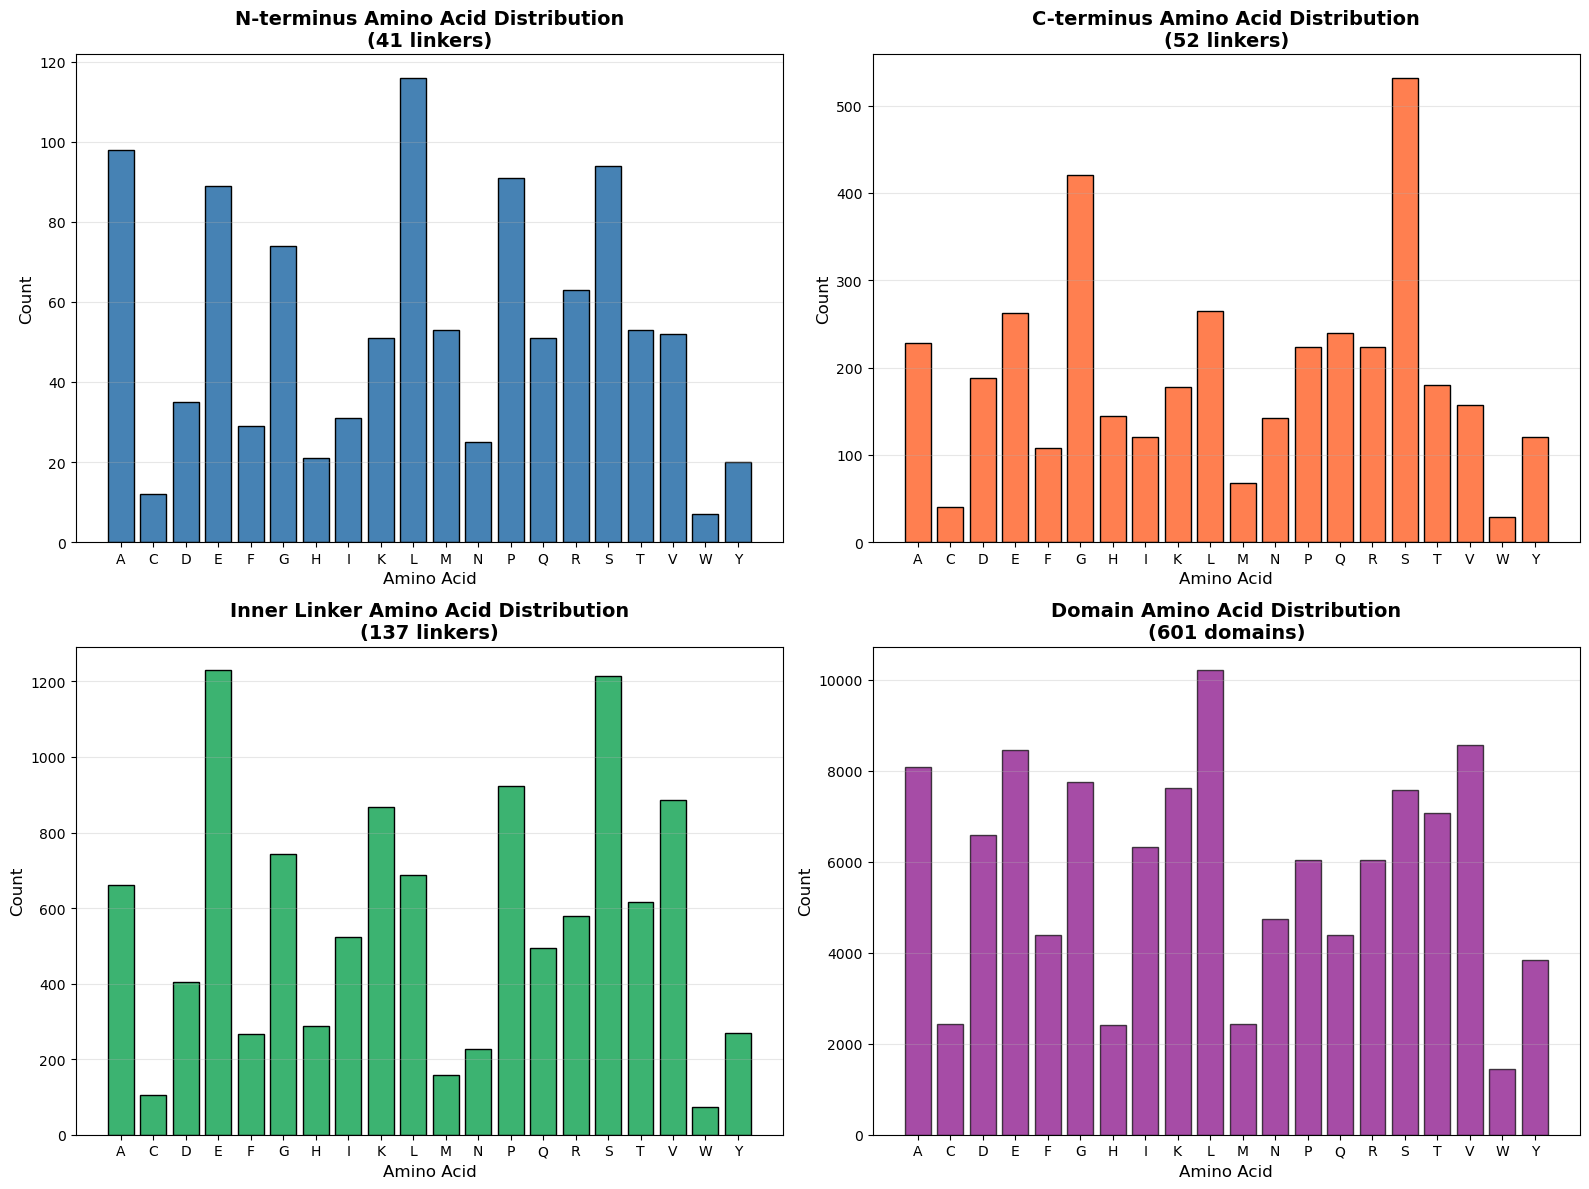

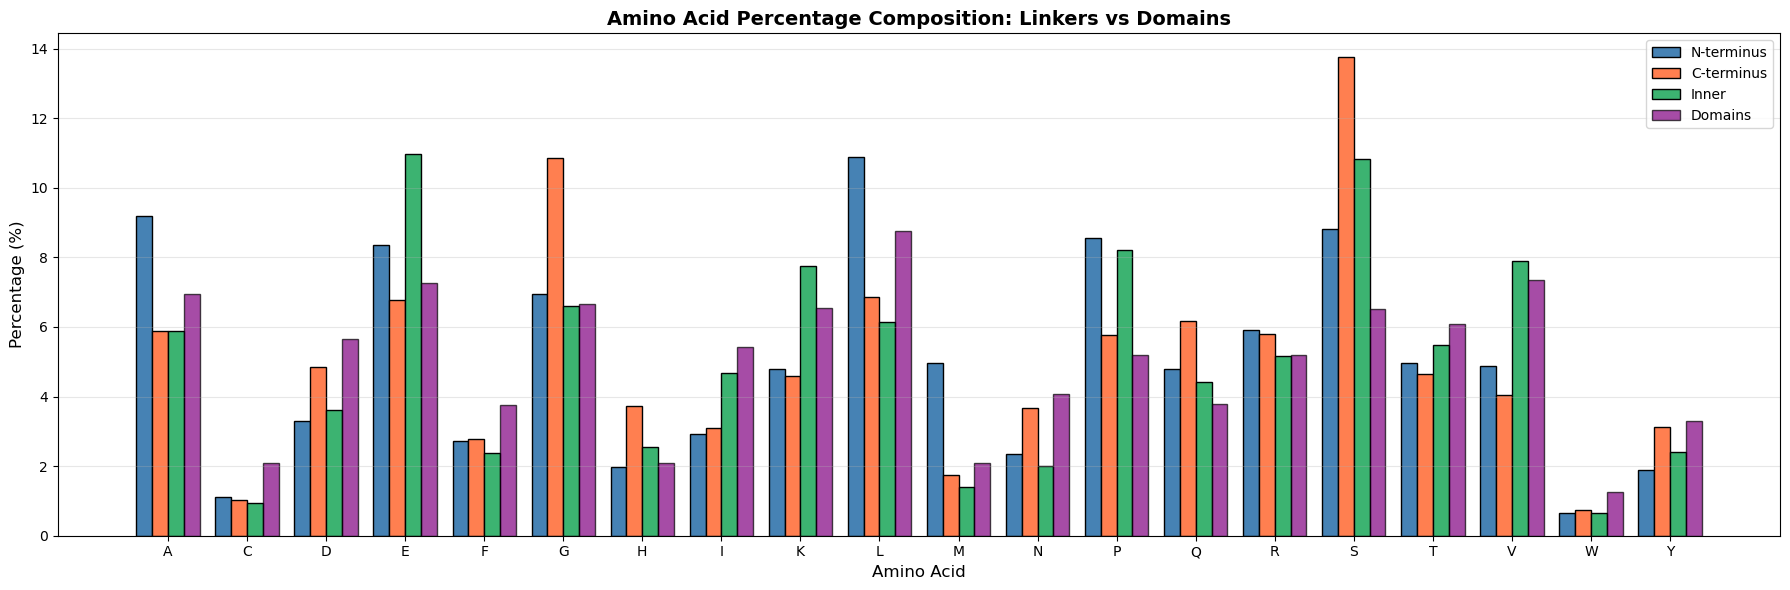

/tmp/ipykernel_1597/2910822069.py:357: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,


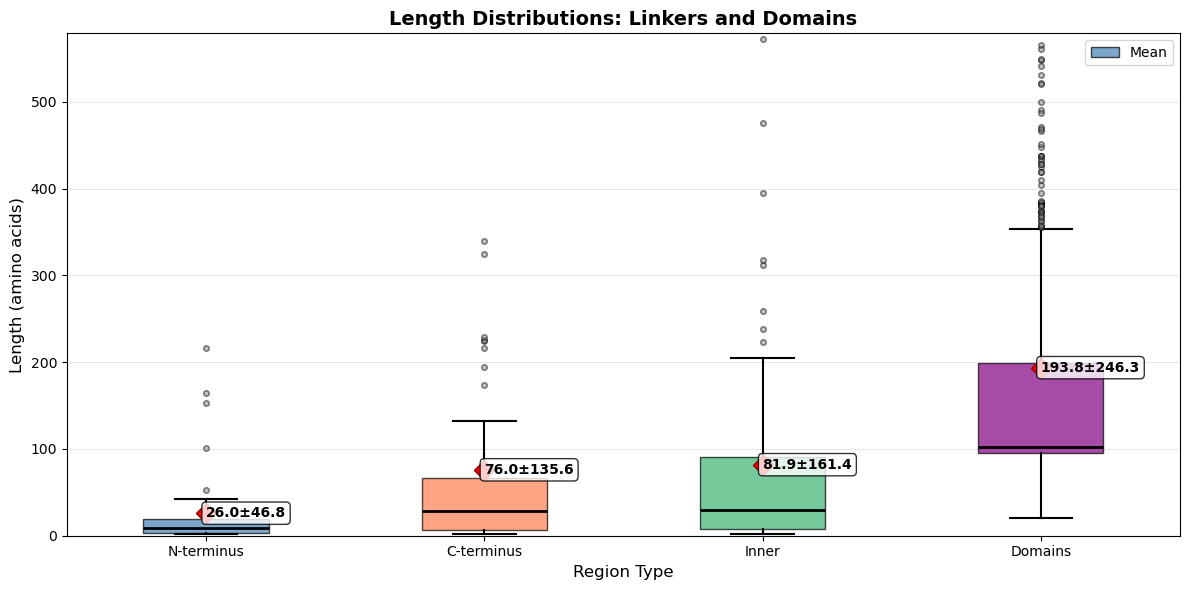


=== Length Statistics ===
N-terminus: mean=26.0, median=9.0, std=46.8, n=41
C-terminus: mean=76.0, median=28.5, std=135.6, n=52
Inner:      mean=81.9, median=30.0, std=161.4, n=137
Domains:    mean=193.8, median=102.0, std=246.3, n=601

[2/2] Creating domain vs linker comparison...


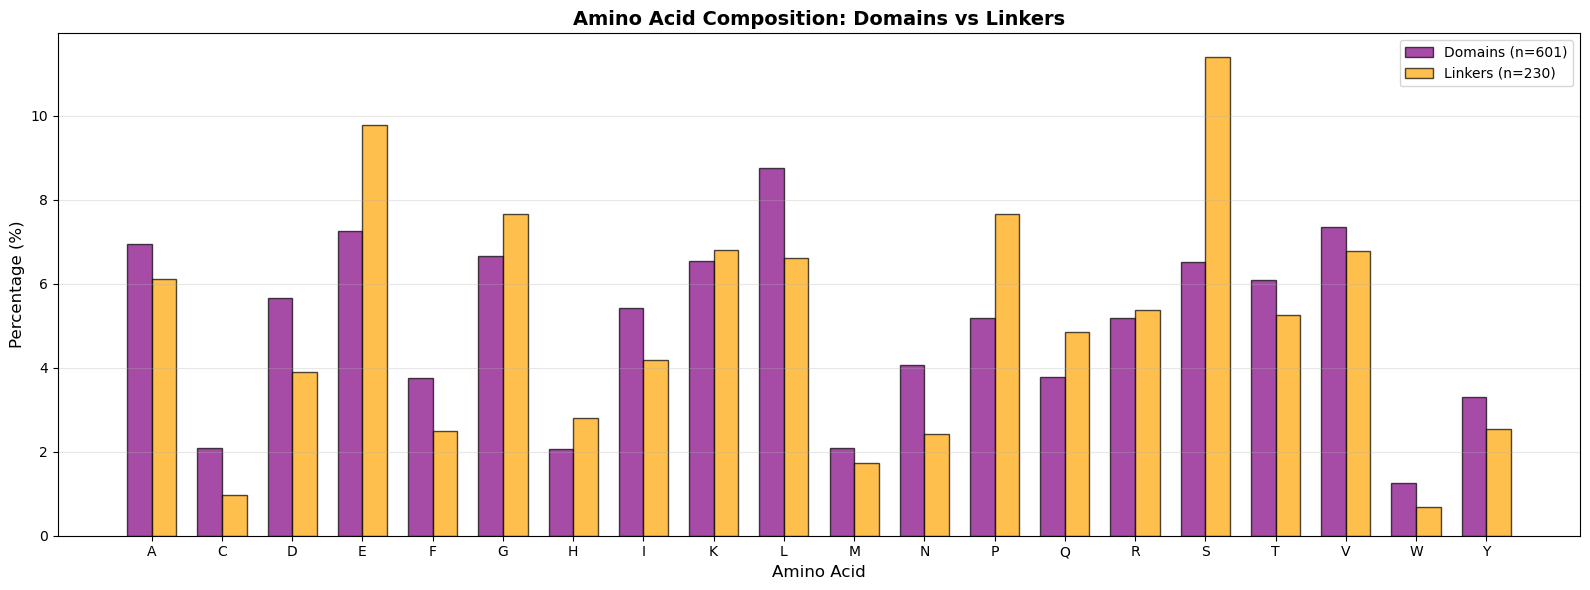


✓ ANALYSIS COMPLETE!
All plots saved to: /home/pospim/Desktop/work/protein_linkers


In [12]:
import requests, math, os, json
from collections import defaultdict, Counter
import pandas as pd

# ================================
# Configuration
# ================================
workdir = "~/Desktop/work/protein_linkers"
protein_file = os.path.expanduser(f"{workdir}/proteins.tsv")
fasta_path = os.path.expanduser(f"{workdir}/proteins.fa")
json_file = os.path.expanduser(f"{workdir}/formatted_proteins.json")

# Load formatted proteins
with open(json_file, 'r') as f:
    proteins_dict = json.load(f)

# Load FASTA sequences
sequences_dict = {}
with open(fasta_path, 'r') as f:
    current_acc = None
    current_seq = []
    for line in f:
        line = line.strip()
        if line.startswith('>'):
            if current_acc:
                sequences_dict[current_acc] = ''.join(current_seq)
            current_acc = line[1:]
            current_seq = []
        else:
            current_seq.append(line)
    if current_acc:
        sequences_dict[current_acc] = ''.join(current_seq)
print(f"✓ Loaded {len(sequences_dict)} sequences from proteins.fa")

# Convert formatted data to analysis-ready structure
# formatted_proteins.json already has domains as [name, start, end] and linkers as [type, length]
domains = []
for accession, data in proteins_dict.items():
    # Convert domain tuples to dicts
    domain_dicts = [{'name': d[0], 'start': d[1], 'end': d[2]} for d in data['domains']]

    # We need to reconstruct linker coordinates from domain gaps for sequence extraction
    # (formatted_proteins only has linker type and length, not start/end coords)
    linker_coords = []
    seq = sequences_dict.get(accession)
    if seq and domain_dicts:
        protein_length = len(seq)
        sorted_domains = sorted(domain_dicts, key=lambda x: x['start'])

        # N-terminal linker
        if sorted_domains[0]['start'] > 1:
            linker_coords.append({
                'start': 1,
                'end': sorted_domains[0]['start'] - 1
            })

        # Inner linkers
        for i in range(len(sorted_domains) - 1):
            gap_start = sorted_domains[i]['end'] + 1
            gap_end = sorted_domains[i + 1]['start'] - 1
            if gap_start < gap_end:
                linker_coords.append({
                    'start': gap_start,
                    'end': gap_end
                })

        # C-terminal linker
        if sorted_domains[-1]['end'] < protein_length:
            linker_coords.append({
                'start': sorted_domains[-1]['end'] + 1,
                'end': protein_length
            })

    domains.append({
        'uniprot_acc': accession,
        'domains': domain_dicts,
        'linkers': linker_coords
    })

print(f"✓ Loaded {len(domains)} protein structures from formatted data")

# ================================
# Run Analyses
# ================================
print("\n" + "="*60)
print("LINKER ANALYSIS")
print("="*60)
n_terminus_counter, c_terminus_counter, inner_counter, n_count, c_count, i_count, n_lengths, c_lengths, i_lengths = analyze_linkers(
    proteins_dict, sequences_dict, domains
)

print("\n" + "="*60)
print("DOMAIN ANALYSIS")
print("="*60)
domain_counter, domain_count, domain_lengths = analyze_domains(sequences_dict, domains)

# ================================
# Create Visualizations
# ================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

print("\n[1/2] Creating combined linker and domain visualizations...")
visualize_linker_composition(n_terminus_counter, c_terminus_counter, inner_counter,
                             n_count, c_count, i_count, n_lengths, c_lengths, i_lengths,
                             domain_counter, domain_count, domain_lengths,
                             save_dir=workdir)

print("\n[2/2] Creating domain vs linker comparison...")
compare_domains_vs_linkers(domain_counter, domain_count,
                           n_terminus_counter, c_terminus_counter, inner_counter,
                           n_count, c_count, i_count, save_dir=workdir)

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print(f"All plots saved to: {os.path.expanduser(workdir)}")
print("="*60)


In [ ]:
def cath_gene3d(uniprot_acc):
    """
    Pull CATH FunFams for a UniProt and infer domain spans if present.
    (Some responses include mapped regions to the sequence.)
    """
    url = f"{CATH_URL}/{uniprot_acc}?content-type=application/json"
    r = requests.get(url, timeout=30)
    if r.status_code == 404:
        return []
    r.raise_for_status()
    data = r.json()
    hits = []
    for ff in data.get("data", []) if isinstance(data, dict) else data:
        sfam = ff.get("superfamily_id")
        funfam = ff.get("funfam_number")
        for reg in ff.get("regions", []):
            hits.append({
                "db": "CATH-Gene3D",
                "accession": f"{sfam}/FF{funfam}",
                "start": reg.fet("aln_start") or reg.get("start"),
                "end": reg.get("aln_end") or reg.get("end"),
                "score": reg.get("evalue") or reg.get("bitscore")
            })
    return sorted([h for h in hits if h["start"] and h["end"]], key=lambda h: (h["start"], h["end"]))
